In [91]:
cd ~/PycharmProjects/IMyGLight/OMyGA/

/Users/jz-rolling/PycharmProjects/IMyGLight/OMyGA


In [92]:
import OMEGA as om2

In [93]:
import OMEGA_core as om
import timeit
from numba import jit
import numpy as np
from skimage import morphology, exposure
from scipy.interpolate import splprep, splev, RectBivariateSpline
import tifffile
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob, os
import pdb, pickle, time
import shutil
from scipy import stats
import scipy.ndimage as ndi
import pickle as pk

In [451]:
output_folder = '/Volumes/Extreme_SSD/Other_imaging_data/20210725_MSR_drug/3hrs_selected/'
#t1 = timeit.default_timer()
n=0
# redo MSR_08_H02_MSMEG_4230
#for folder in glob.glob('/Volumes/NGDRPSGG/MSR/MSR_data_uniformat/input/MSR*/'):
for folder in glob.glob('/Volumes/Extreme_SSD/Other_imaging_data/20210725_MSR_drug/3hrs/*/'):
    if '3053' in folder or '4625' in folder:
    #if '4625_BDQ' in folder:
        header = folder.split('/')[-2]
        subfolder = output_folder+'{}/'.format(header)
        if len(glob.glob(folder+'*.nd2')) != 0:
            om.io.process_folder(source_folder=folder,
                         dest_folder=subfolder,
                         mask_channel_id=-1,
                         save_segmentation_result=True,
                         configfile="/Users/jz-rolling/Desktop/OMEGA/OMEGA_core/configurations/configuration_mtb_coarse.ini",
                         boundary_classifier='/Users/jz-rolling/Desktop/OMEGA/OMEGA_core/configurations/boundary_MLP.pk',
                         boundary_normalizer='/Users/jz-rolling/Desktop/OMEGA/OMEGA_core/configurations/normalizer.pk',
                         n_cores=10)
            om.io.measure_by_folder(header=header, dest_folder=subfolder)

In [99]:
def pole_aware_stack(pickled_cells, cell_dataframe,channel,
                     reorientation=True):
    from skimage.transform import resize, rescale
    # retrieve cell indices
    qualified = np.where((cell_dataframe['is_outlier']==0)&(cell_dataframe['Quality_by_shape_index']==1))[0]
    stacks = []
    lengths = []
    for i in qualified:
        data = cells[i].measurements.signal_measurements[channel]['straighten']
        data[data<0]=0
        if reorientation:
            half_l = int(data.shape[1]/2)
            if np.average(data[:,:half_l])<np.average(data[:,half_l:]):
                data = np.flip(data,axis=1)
        #data = gaussian(data,sigma=1)
        upscaled = rescale(data,(2,2),anti_aliasing=True)
        l = cells[i].measurements.morphology_measurements['length']
        pole_length = int(round((0.3/l)*upscaled.shape[1]))
        pole1 = resize(upscaled[:,:pole_length],(15,3),anti_aliasing=True)
        cell_body = resize(upscaled[:,pole_length:-pole_length],(15,24),anti_aliasing=True)
        pole2 = resize(upscaled[:,-pole_length:],(15,3),anti_aliasing=True)
        stitched = np.concatenate([pole1,cell_body,pole2], axis=1).flatten()
        stitched = stitched/stitched.mean()
        #stitched = om.helper.ndi.maximum_filter(stitched,size=2).flatten()
        stacks.append(stitched)
        lengths.append(l)
    return np.array(stacks), qualified, np.array(lengths)


def min_max_normalization(data, pad=0.01):
    return ((data-data.min())/(data.max()-data.min())+pad)/(1+pad)

def length_based_stack(cellpics, lengths, n=13, pad=10, remove_extreme_perc=0.05):
    
    extrema = int(len(lengths)*remove_extreme_perc)
    sorted_stack = cellpics.copy()[np.argsort(lengths)][extrema:-extrema]
    lengths_sorted = np.sort(lengths)[extrema:-extrema]
    stack_average=[]
    lengths_average=[]

    for i in range(n):
        id1 = int(i*(len(lengths_sorted)/n))
        id2 = int((i+1)*(len(lengths_sorted)/n))+pad
        averaged = np.average(sorted_stack[id1:id2],axis=0)
        averaged = filters.gaussian(averaged.reshape(15,30),sigma=0.5).flatten()
        averaged = averaged/np.mean(averaged)
        stack_average.append(averaged)
        lengths_average.append(np.average(lengths_sorted[id1:id2]))
        
    return np.array(stack_average), np.array(lengths_average)

def smooth_input(cellpics,h=15,w=30):
    smoothed = np.zeros(cellpics.shape)
    for i in range(cellpics.shape[0]):
        img = cellpics[i].reshape(h,w)
        smoothed[i] = (filters.gaussian(img,sigma=1)).reshape(h*w)
    return smoothed

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [472]:
# load GEMATRIA model
# save data
dest_folder = '/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/NMF_output/'
w = np.load(dest_folder+'NMF_encoding.npy')
h = np.load(dest_folder+'NMF_basis.npy')
model = pickle.load(open(dest_folder+'NMF_model.pk','rb'))
npy_folder='/Volumes/Extreme_SSD/Other_imaging_data/20210725_MSR_drug/GEM_transformed/'
for f in sorted(glob.glob(output_folder+'*/')):
    key = f.split('/')[-2]
    channel='FITC'
    cells = om.io.pickle_load_all_cells(f)
    df = pd.read_excel('{}{}_accepted_cells_morphology.xls'.format(f,key))
    df_fl = pd.read_excel('{}{}_accepted_cells_FITC.xls'.format(f,key))
    df_ph = pd.read_excel('{}{}_accepted_cells_Phase_Ian.xls'.format(f,key))
    fl_cols = ['{}_{}'.format(channel,x) for x in df_fl.columns[4:-1]]
    ph_cols = ['{}_{}'.format('Phase',x) for x in df_ph.columns[4:-1]]
    fl_isoutlier = df_fl['is_outlier'].values
    ph_isoutlier = df_ph['is_outlier'].values
    morph_outlier = df['is_outlier'].values
    isoutlier = ((fl_isoutlier+ph_isoutlier+morph_outlier)>0)*1
    
    df[fl_cols] = df_fl[df_fl.columns[4:-1]]
    df[ph_cols] = df_ph[df_ph.columns[4:-1]]
    df['is_outlier'] = isoutlier
    quality_score=[]
    for cell in cells:
        quality = 0
        shpid = cell.measurements.signal_measurements['Shape_index']['axial']
        shpid = np.interp(np.linspace(0,1,100),np.linspace(0,1,len(shpid)),shpid)
        #changed threshold from 32 to 45
        below_th = np.where(shpid<45)[0]
        #extended boundary to 10% from each pole
        if len(below_th)>2:
            if below_th[0] <=10 and below_th[-1]>=90:
                quality=1
        quality_score.append(quality)
    df['Quality_by_shape_index']=quality_score
    stacks, _x, lengths = pole_aware_stack(cells, df, channel, reorientation=True)
    qualified_df = df.iloc[_x].reset_index(drop=True)
    qualified_df[['GEM_{}'.format(i) for i in range(1,21)]] = model.transform(stacks)
    qualified_df.to_csv(npy_folder+'merged_df_{}.csv'.format(key))
    np.save(npy_folder+'{}_{}.npy'.format(key,channel),stacks)
    np.save(npy_folder+'{}_lengths.npy'.format(key),lengths)
    filtered_cells = [cells[x] for x in _x]
    pk.dump(filtered_cells,open('{}{}_filtered_cells.pk'.format(npy_folder,key),'wb'))

In [96]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap


# test_fun
npy_folder='/Volumes/Extreme_SSD/Other_imaging_data/20210725_MSR_drug/GEM_transformed/'
merged_df = []
merged_cells = []
for f in sorted(glob.glob('/Volumes/Extreme_SSD/Other_imaging_data/20210725_MSR_drug/GEM_transformed/*.csv')):
    df = pd.read_csv(f)
    locus,drug = f.split('/')[-1].split('.')[0].split('_')[-2:]
    df['locus'] = ['MSMEG_{}'.format(locus)]*len(df)
    df['treatment'] = [drug]*len(df)
    df['entry'] = ['MSMEG_{}_{}'.format(locus,drug)]*len(df)
    merged_df.append(df)
    merged_cells += pk.load(open('{}{}_{}_filtered_cells.pk'.format(npy_folder,locus,drug),'rb'))
merged_df = pd.concat(merged_df)
merged_df['cell_index'] = np.arange(len(merged_df))


In [97]:
filtered_df = merged_df[(merged_df['FITC_mean']>64)&(merged_df['width_median']>0.65)].copy()
gene_names = []
treatments = []
for g,t in filtered_df[['locus','treatment']].values:
    if g=='MSMEG_3053':
        name='RpoZ-Dendra'
    else:
        name='RplU-Dendra'
    if t=='untreated':
        t='DMSO'
    gene_names.append(name)
    treatments.append(t)
filtered_df['treatment'] = treatments
filtered_df['strain'] = gene_names


gem_cols = ['GEM_{}'.format(x) for x in np.arange(1,21)]
data = filtered_df[gem_cols].values
norm_features = data/np.sum(data,axis=1)[:,np.newaxis]
normd = StandardScaler().fit_transform(data)
pca=PCA(n_components=2)
filtered_df[['PC1','PC2']] = pca.fit_transform(normd)
filtered_df[['umap1','umap2']] = umap.UMAP(n_neighbors=100,min_dist=0.8,\
                                         metric="euclidean",\
                                        n_components=2,random_state=41).fit_transform(normd)

filtered_df.to_csv('/Volumes/Extreme_SSD/Other_imaging_data/20210725_MSR_drug/GEM_pca_filtered.csv')

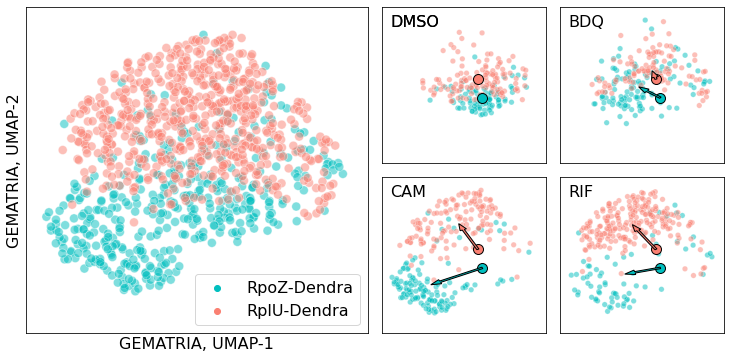

In [159]:
from matplotlib.gridspec import GridSpec as gs
fig=plt.figure(figsize=(12.5,6))
# Create an array with the colors you want to use
colors = ['c','salmon']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
grids = gs(4,8)
ax1 = fig.add_subplot(grids[:,:4])
ax2 = fig.add_subplot(grids[:2,4:6])
ax3 = fig.add_subplot(grids[:2,6:])
ax4 = fig.add_subplot(grids[2:,4:6])
ax5 = fig.add_subplot(grids[2:,6:])

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_xlim(-6,4.5)
    ax.set_ylim(4.5,20)
    ax.set_xticks([])
    ax.set_yticks([])
ax1.set_xlabel('GEMATRIA, UMAP-1',fontsize=16)
ax1.set_ylabel('GEMATRIA, UMAP-2',fontsize=16)
    
#
sns.scatterplot(data=filtered_df, x='umap1',y='umap2',hue='strain',s=80,alpha=0.5, ax=ax1)
ax1.legend(prop={'size':16})

treatments = ['DMSO','BDQ','CAM','RIF']
strains = ['RpoZ-Dendra','RplU-Dendra']
geocenters = {}
for s in strains:
    if s not in geocenters:
        geocenters[s] = {}
    for t in treatments:
        subset = filtered_df[(filtered_df['treatment']==t)&(filtered_df['strain']==s)]
        geocenters[s][t] = centeroidnp(subset[['umap1','umap2']].values)

    
    

sns.scatterplot(data=filtered_df[filtered_df['treatment']=='DMSO'], x='umap1',y='umap2',hue='strain', 
                s=30,alpha=0.5,ax=ax2,legend=False)
ax2.text(-5.5,18,'DMSO',fontsize=16)
x1,y1 = geocenters[strains[0]]['DMSO']
ax2.scatter(x1,y1,s=100,fc='c',ec='black')
x2,y2 = geocenters[strains[1]]['DMSO']
ax2.scatter(x2,y2,s=100,fc='salmon',ec='black')

sns.scatterplot(data=filtered_df[filtered_df['treatment']=='BDQ'], x='umap1',y='umap2',hue='strain',
                s=30,alpha=0.5,ax=ax3,legend=False)
ax3.text(-5.5,18,'BDQ',fontsize=16)
ax2.text(-5.5,18,'DMSO',fontsize=16)

x3,y3 = geocenters[strains[0]]['BDQ']
ax3.scatter(x1,y1,s=100,fc='c',ec='black')
ax3.arrow(x1,y1,x3-x1,y3-y1,width=0.15,fc='c',length_includes_head=True)

x4,y4 = geocenters[strains[1]]['BDQ']
ax3.scatter(x2,y2,s=100,fc='salmon',ec='black')
ax3.arrow(x2,y2,x4-x2,y4-y2,width=0.15,fc='salmon',length_includes_head=True)

sns.scatterplot(data=filtered_df[filtered_df['treatment']=='CAM'], x='umap1',y='umap2',hue='strain',
                s=30,alpha=0.5,ax=ax4,legend=False)
ax4.text(-5.5,18,'CAM',fontsize=16)

x5,y5 = geocenters[strains[0]]['CAM']
ax4.scatter(x1,y1,s=100,fc='c',ec='black')
ax4.arrow(x1,y1,x5-x1,y5-y1,width=0.15,fc='c',length_includes_head=True)

x6,y6 = geocenters[strains[1]]['CAM']
ax4.scatter(x2,y2,s=100,fc='salmon',ec='black')
ax4.arrow(x2,y2,x6-x2,y6-y2,width=0.15,fc='salmon',length_includes_head=True)

sns.scatterplot(data=filtered_df[filtered_df['treatment']=='RIF'], x='umap1',y='umap2',hue='strain',
                s=30,alpha=0.5,ax=ax5,legend=False)
ax5.text(-5.5,18,'RIF',fontsize=16)

x7,y7 = geocenters[strains[0]]['RIF']
ax5.scatter(x1,y1,s=100,fc='c',ec='black')
ax5.arrow(x1,y1,x7-x1,y7-y1,width=0.15,fc='c',length_includes_head=True)

x8,y8 = geocenters[strains[1]]['RIF']
ax5.scatter(x2,y2,s=100,fc='salmon',ec='black')
ax5.arrow(x2,y2,x8-x2,y8-y2,width=0.15,fc='salmon',length_includes_head=True)

plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/drug_treatment/umap.png',bbox_inches='tight',dpi=160)

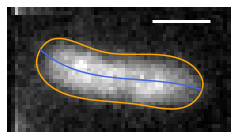

In [101]:
om.plot.plot_cell(merged_cells[subset['cell_index'].values[3]],channel='FITC',lw=1.5,scale_bar=True)

In [205]:
# find RIF RplU outliers

rplU_cam = filtered_df[(filtered_df['strain']=='RpoZ-Dendra')&(filtered_df['treatment']=='RIF')][['umap1','umap2']].values
rplU_dmso_centroid = geocenters['RplU-Dendra']['DMSO']
indices = filtered_df[(filtered_df['strain']=='RpoZ-Dendra')&(filtered_df['treatment']=='RIF')]['cell_index'].values
distance = np.sqrt(np.sum(np.square(rplU_cam-np.array(rplU_dmso_centroid)[np.newaxis,:]),axis=1))
close_neighbors = indices[np.argsort(distance)[:20]]

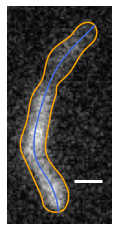

In [214]:
om.plot.plot_cell(merged_cells[close_neighbors[12]],channel='FITC',lw=1.5,scale_bar=True)

In [102]:
fig=plt.figure(figsize=(8.5,2))
# Create an array with the colors you want to use
colors = ['c','salmon']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.boxplot(data=norm_data,x='treatment',y='Pole_weight',hue='strain',width=0.8,order=['DMSO','CAM','RIF','BDQ'])
plt.ylim(-0.01,0.2)
plt.ylabel('pole association\n(features 4 + 6)',fontsize=14)
plt.xlabel('')
plt.xticks([0,1,2,3],['DMSO','CAM','RIF','BDQ'],fontsize=14)
plt.legend(prop={'size':12})
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/drug_treatment/pole_deplet.png',bbox_inches='tight',dpi=160)

NameError: name 'norm_data' is not defined

<Figure size 612x144 with 0 Axes>

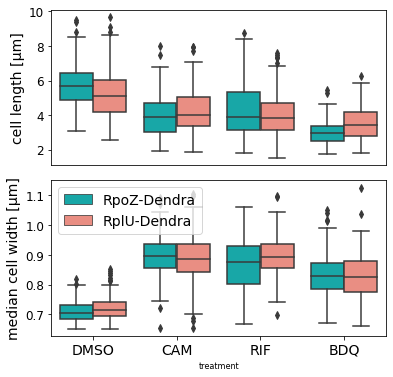

In [794]:
fig=plt.figure(figsize=(6,6))
# Create an array with the colors you want to use
colors = ['c','salmon']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
grids = gs(2,1,hspace=0.1)
ax1 = fig.add_subplot(grids[0,:])
ax2 = fig.add_subplot(grids[1,:])
sns.boxplot(data=filtered_df,x='treatment',y='length',hue='strain',order=['DMSO','CAM','RIF','BDQ'],ax=ax1)
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.get_legend().remove()
ax1.set_yticks([2,4,6,8,10])
ax1.set_yticklabels([2,4,6,8,10],fontsize=12)
ax1.set_ylabel('cell length [μm]',fontsize=14)
sns.boxplot(data=filtered_df,x='treatment',y='width_median',hue='strain',order=['DMSO','CAM','RIF','BDQ'],ax=ax2)
ax2.set_xticklabels(['DMSO','CAM','RIF','BDQ'],fontsize=14);
ax2.set_yticks([0.7,0.8,0.9,1.0,1.1])
ax2.set_yticklabels([0.7,0.8,0.9,1.0,1.1],fontsize=12)
ax2.set_ylabel('median cell width [μm]',fontsize=14)
ax2.legend(prop={'size':14})
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/drug_treatment/morph.png',bbox_inches='tight',dpi=160)

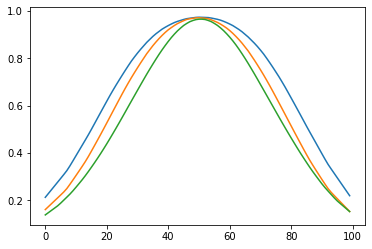

In [21]:
df = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_curated.xls')

lateral_data = {}
for l in ['MSMEG_1364','MSMEG_1524']:
    k = df[df['locus']==l]['key'].values[0]
    folder = '/Volumes/Junhao_data_Rubin_Lab/MSR_submission1_archive_202103/MSR_update_20201118/{}/'.format(k)
    data = om.io.pk.load(open(folder+'{}_miscellaneous_data.pk'.format(k),'rb'))
    lateral_data[l] = data['FITC']['width_normalized_lateral_data']
    plt.plot(np.mean(data['FITC']['width_normalized_lateral_data'],axis=0))

h33342 = om.io.pk.load(open('/Volumes/Junhao_data_Rubin_Lab/MSR_spike_in_data/2021_rerun/H33342/H33342_miscellaneous_data.pk','rb'))
lateral_data['H33342']=h33342['DAPI']['width_normalized_lateral_data']
plt.plot(np.mean(h33342['DAPI']['width_normalized_lateral_data'],axis=0))

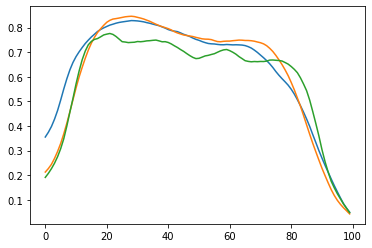

In [62]:
df = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_curated.xls')

axial_data = {}
for l in ['MSMEG_1364','MSMEG_1524']:
    k = df[df['locus']==l]['key'].values[0]
    folder = '/Volumes/Junhao_data_Rubin_Lab/MSR_submission1_archive_202103/MSR_update_20201118/{}/'.format(k)
    data = om.io.pk.load(open(folder+'{}_miscellaneous_data.pk'.format(k),'rb'))
    axial_data[l] = data['FITC']['length_normalized_axial_data']
    plt.plot(np.mean(data['FITC']['length_normalized_axial_data'],axis=0))

h33342 = om.io.pk.load(open('/Volumes/Junhao_data_Rubin_Lab/MSR_spike_in_data/2021_rerun/H33342/H33342_miscellaneous_data.pk','rb'))
axial_data['H33342']=h33342['DAPI']['length_normalized_axial_data']
plt.plot(np.mean(h33342['DAPI']['length_normalized_axial_data'],axis=0))

In [40]:
def confidence_interval(data):
    from scipy import stats
    return stats.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data)) 

def random_flip(data):
    rand_flipped = []
    for x in data:
        if np.random.randint(2) == 0:
            rand_flipped.append(np.flip(x))
        else:
            rand_flipped.append(x)
    return np.array(rand_flipped)

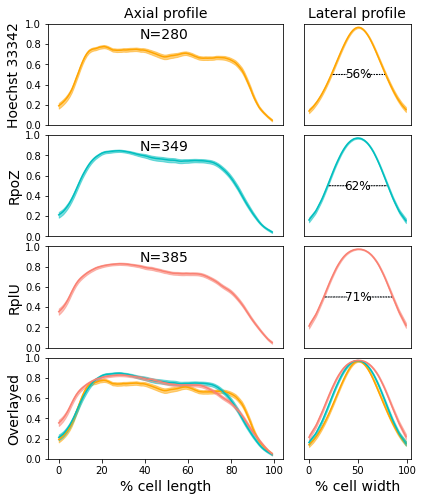

In [89]:
#plot axial data
from matplotlib.gridspec import GridSpec as gs
fig=plt.figure(figsize=(6.5,8))
grids = gs(4,3,hspace=0.1,wspace=0.2)
ax1 = [fig.add_subplot(grids[0,:2]),fig.add_subplot(grids[0,2])]
ax2 = [fig.add_subplot(grids[1,:2]),fig.add_subplot(grids[1,2])]
ax3 = [fig.add_subplot(grids[2,:2]),fig.add_subplot(grids[2,2])]
ax4 = [fig.add_subplot(grids[3,:2]),fig.add_subplot(grids[3,2])]

keys = ['H33342','MSMEG_1524','MSMEG_1364']
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax[1].set_yticks([])
    ax[0].set_ylim(0,1)
    ax[1].set_ylim(0,1)
    if i != 3:
        for subax in ax:
            subax.set_xticks([])
    if i ==0:
        ax[0].set_title('Axial profile',fontsize=14)
        ax[1].set_title('Lateral profile',fontsize=14)
    if i ==3:
        ax[0].set_xlabel('% cell length',fontsize=14)
        ax[1].set_xlabel('% cell width',fontsize=14)

colors = ['orange','c','salmon']
names = ['Hoechst 33342','RpoZ','RplU']
for i,ax in enumerate([ax1,ax2,ax3]):
    k = keys[i]
    axial = axial_data[k]
    lateral = lateral_data[k]
    axial_conf = np.apply_along_axis(confidence_interval,0,axial)
    lateral_conf = np.apply_along_axis(confidence_interval,0,lateral)
    ax[0].plot(np.mean(axial,axis=0),color=colors[i])
    ax[1].plot(np.mean(lateral,axis=0),color=colors[i])
    ax[0].fill_between(np.arange(axial.shape[1]),axial_conf[0],axial_conf[1],color=colors[i],alpha=0.5)
    ax[1].fill_between(np.arange(lateral.shape[1]),lateral_conf[0],lateral_conf[1],color=colors[i],alpha=0.5)
    ax4[0].plot(np.mean(axial,axis=0),color=colors[i])
    ax4[1].plot(np.mean(lateral,axis=0),color=colors[i])
    ax4[0].fill_between(np.arange(axial.shape[1]),axial_conf[0],axial_conf[1],color=colors[i],alpha=0.5)
    ax4[1].fill_between(np.arange(lateral.shape[1]),lateral_conf[0],lateral_conf[1],color=colors[i],alpha=0.5)
    ax[0].text(49,0.85,'N={}'.format(len(axial)),fontsize=14,ha='center')
    ax[0].set_ylabel(names[i],fontsize=14)
    
    lateral_mean = np.mean(lateral,axis=0)
    loc = np.where(lateral_mean>0.5)[0]
    ax[1].arrow(39,0.5,(loc[0]-39),0,ls=':',lw=1)
    ax[1].arrow(60,0.5,(loc[-1]-60),0,ls=':',lw=1)
    ax[1].text(50,0.5,'{}%'.format(len(loc)),fontsize=12,ha='center',va='center')
ax4[0].set_ylabel('Overlayed',fontsize=14)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/drug_treatment/axial_lateral.png',bbox_inches='tight',dpi=160)

In [ ]:
confidence_interval()

In [18]:
output_folder = '/Volumes/Junhao_data_Rubin_Lab/MSR_spike_in_data/2021_rerun/'
#t1 = timeit.default_timer()
n=0
# redo MSR_08_H02_MSMEG_4230
#for folder in glob.glob('/Volumes/NGDRPSGG/MSR/MSR_data_uniformat/input/MSR*/'):
for folder in glob.glob('/Volumes/Junhao_data_Rubin_Lab/MSR_spike_in_data/selected_input/H33342/'):
    header = folder.split('/')[-2]
    subfolder = output_folder+'{}/'.format(header)
    if len(glob.glob(folder+'*.nd2')) != 0:
        om.io.process_folder(source_folder=folder,
                         dest_folder=subfolder,
                         mask_channel_id=-1,
                         save_segmentation_result=True,
                         configfile="/Users/jz-rolling/Desktop/OMEGA/OMEGA_core/configurations/configuration_mtb_coarse.ini",
                         boundary_classifier='/Users/jz-rolling/Desktop/OMEGA/OMEGA_core/configurations/boundary_MLP.pk',
                         boundary_normalizer='/Users/jz-rolling/Desktop/OMEGA/OMEGA_core/configurations/normalizer.pk',
                         n_cores=10)
        om.io.measure_by_folder(header=header, dest_folder=subfolder)

In [109]:
filtered_df.columns[5:50]

Index(['eccentricity', 'solidity', 'circularity', 'convexity',
       'average_bending_energy', 'min_curvature', 'max_curvature',
       'mean_curvature', 'std_curvature', 'rough_Length', 'rough_sinuosity',
       'branch_count', 'length', 'sinuosity', 'width_median', 'width_std',
       'width_max', 'width_minwidth_symmetry', 'is_outlier', 'FITC_median',
       'FITC_mean', 'FITC_max', 'FITC_min', 'FITC_standard_deviation',
       'FITC_midline_skewness', 'FITC_midline_kurtosis', 'FITC_cell_kurtosis',
       'FITC_cell_skewness', 'FITC_axial_symmetry', 'FITC_lateral_FWHM',
       'FITC_lateral_center_offset', 'FITC_normalized_lateral_FWHM',
       'FITC_lateral_symmetry', 'Phase_median', 'Phase_mean', 'Phase_max',
       'Phase_min', 'Phase_standard_deviation', 'Phase_midline_skewness',
       'Phase_midline_kurtosis', 'Phase_cell_kurtosis', 'Phase_cell_skewness',
       'Phase_axial_symmetry', 'Phase_lateral_FWHM',
       'Phase_lateral_center_offset'],
      dtype='object')

In [129]:
morph_cols = ['eccentricity','solidity', 'circularity', 'convexity','sinuosity',
 'average_bending_energy', 'min_curvature', 'max_curvature',
 'mean_curvature', 'std_curvature','length','width_median','width_std','width_max']

In [148]:
morph_norm = StandardScaler().fit_transform(filtered_df[morph_cols].values)
filtered_df[['morph_umap1','morph_umap2']] = umap.UMAP(n_neighbors=50,min_dist=0.2,\
                                             metric="euclidean",\
                                             n_components=2,random_state=23).fit_transform(morph_norm)

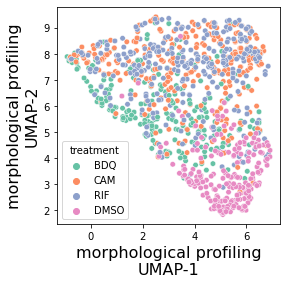

In [224]:
fig=plt.figure(figsize=(4,4))
colors = ['c','salmon']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data=filtered_df,x='morph_umap1',y='morph_umap2',hue='treatment',palette='Set2',alpha=1,s=30)
plt.xlabel('morphological profiling\nUMAP-1',fontsize=16)
plt.ylabel('morphological profiling\nUMAP-2',fontsize=16)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/drug_treatment/morph_umap_1.png',bbox_inches='tight',dpi=160)

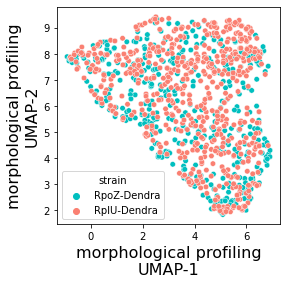

In [225]:
fig=plt.figure(figsize=(4,4))
colors = ['c','salmon']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data=filtered_df,x='morph_umap1',y='morph_umap2',hue='strain',s=30)
plt.xlabel('morphological profiling\nUMAP-1',fontsize=16)
plt.ylabel('morphological profiling\nUMAP-2',fontsize=16)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/drug_treatment/morph_umap_2.png',bbox_inches='tight',dpi=160)